In [2]:
import pandas as pd
from nltk.tokenize import word_tokenize
import string

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\redic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from pymorphy2 import MorphAnalyzer

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Загрузка датасета и описание его основных характеристик

In [6]:
news = pd.read_csv('Russia_News.csv', encoding='utf-8')

In [7]:
news.head()

,title,topic
0,Microsoft обвиняется в подсуживании в пользу К...,Интернет и СМИ
1,Сайт кандидата в президенты США был взломан на...,Интернет и СМИ
2,ФБР выпустит предупреждение-2000 для правоохра...,Интернет и СМИ
3,Треть российских компьютерных систем не готова...,Интернет и СМИ
4,Интернет скоро похоронит бумажные письма,Интернет и СМИ


В датасете содержаться названия статей и к какой из трех тем ("Интернет и СМИ", "Из жизни", "Путешествия") они принадлежат. Посмотрим количество статей по каждой рубрике.

In [145]:
news['topic'].value_counts()

Интернет и СМИ    44663
Из жизни          27605
Путешествия        6408
Name: topic, dtype: int64

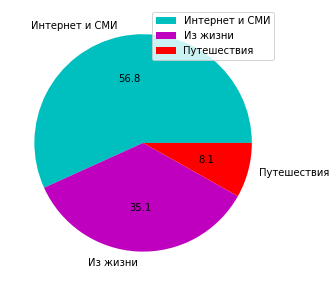

In [144]:
internet = news[news['topic'] == 'Интернет и СМИ'].shape[0]
life = news[news['topic'] == 'Из жизни'].shape[0]
travel = news[news['topic'] == 'Путешествия'].shape[0]
uni_pie = pd.DataFrame({"": [internet, life, travel]},
                       index=["Интернет и СМИ", "Из жизни", "Путешествия"])
uni_pie.plot.pie(y="",
                 colors=["c", "m", "r"],
                 autopct="%.1f",
                 fontsize=10,
                 figsize=(5, 5));

Основные характеристики датасета

In [146]:
from statistics import median
text_of_all_news = []
for t in news['title']:
    text_of_all_news.append(t)
a = 0
for st in text_of_all_news:
    a += int(len(st.split()))
aver_words = a/news.shape[0]
med = []
for t in news['title']:
    med.append(int(len(t.split())))
med = median(med)
print('Количество строк: {}'.format(news.shape[0]))
print('Суммарное количество слов по всем заголовкам: {}'.format(a))
print('Среднее количество слов на один заголовок: {}'.format(aver_words))
print('Медиана количества слов на один заголовок: {}'.format(med))

Количество строк: 78676
Суммарное количество слов по всем заголовкам: 592147
Среднее количество слов на один заголовок: 7.526399410239463
Медиана количества слов на один заголовок: 7.0


# Предобработка текста

In [14]:
list_of_texts = news['title'].to_list()

In [15]:
list_of_texts[:10]

['Microsoft обвиняется в\xa0подсуживании в\xa0пользу Каспарова',
 'Сайт кандидата в\xa0президенты США был взломан на\xa0пять минут',
 'ФБР выпустит предупреждение-2000\xa0для правоохранительных органов',
 'Треть российских компьютерных систем не\xa0готова к\xa02000\xa0году',
 'Интернет скоро похоронит бумажные письма',
 'Центризбирком решил помочь электронным СМИ освещать выборы',
 'Интернет: ты\xa0помнишь, как все начиналось?',
 '"Проблема-2000" может привести к\xa0химической катастрофе',
 'Неизвестный хакер взломал компьютерную сеть в\xa0защиту империи',
 'Морская пехота борется с "червем"']

### Очистим текст от пунктуации, чисел и стоп-слов, приведем все слова к нижнему регистру

In [16]:
import re
nltk.download('stopwords')
nltk.download('punkt')
punct = string.punctuation + "—" + "«" + "»"
from nltk.corpus import stopwords
stopwords_list = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\redic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\redic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
for i in range(len(list_of_texts)):
    list_of_texts[i] = re.sub(r'[0-9]+', ' ', list_of_texts[i])
    list_of_texts[i] = re.sub(r"\b([а-яА-Я]\.)",' ', list_of_texts[i])
    list_of_texts[i] = re.sub(r"\xa0",' ', list_of_texts[i])
    tokens = word_tokenize(list_of_texts[i])    
    tokens = [token.lower() for token in tokens if token not in punct]
    list_of_texts[i] = [word for word in tokens if word not in stopwords_list]

In [18]:
list_of_texts[:5]

[['microsoft', 'обвиняется', 'подсуживании', 'пользу', 'каспарова'],
 ['сайт', 'кандидата', 'президенты', 'сша', 'взломан', 'пять', 'минут'],
 ['фбр', 'выпустит', 'предупреждение-', 'правоохранительных', 'органов'],
 ['треть', 'российских', 'компьютерных', 'систем', 'готова', 'году'],
 ['интернет', 'скоро', 'похоронит', 'бумажные', 'письма']]

### Лемматизация 

In [19]:
import pymorphy2
analyzer = pymorphy2.MorphAnalyzer()

Избавимся от местоимений-существительный, предлогов, союзов, частиц и междометий и прведем оставшиеся слова к начальной форме

In [20]:
all_lemma = []

for i in range(len(list_of_texts)):
    one_lemma = []
    for word in list_of_texts[i]:
        if analyzer.parse(word)[0].tag.POS in ('NPRO', 'PREP', 'CONJ', 'PRCL', 'INTJ'):
            continue
        if analyzer.parse(word)[0].tag.POS is not None:
            one_lemma.append(analyzer.parse(word)[0].normal_form)
    all_lemma.append(one_lemma)

In [21]:
all_lemma[:10]

[['обвиняться', 'подсуживание', 'польза', 'каспаров'],
 ['сайт', 'кандидат', 'президент', 'сша', 'взломать', 'пять', 'минута'],
 ['фбр', 'выпустить', 'правоохранительный', 'орган'],
 ['треть', 'российский', 'компьютерный', 'система', 'готовый', 'год'],
 ['интернет', 'скоро', 'похоронить', 'бумажный', 'письмо'],
 ['центризбирком',
  'решить',
  'помочь',
  'электронный',
  'сми',
  'освещать',
  'выборы'],
 ['интернет', 'помнить', 'начинаться'],
 ['привести', 'химический', 'катастрофа'],
 ['неизвестный',
  'хакер',
  'взломать',
  'компьютерный',
  'сеть',
  'защита',
  'империя'],
 ['морской', 'пехота', 'бороться', 'червь']]

### Разделим наш датасет на обучающую и тестовую части

In [22]:
y = news['topic']

In [23]:
X = [' '.join(text) for text in all_lemma]
X[:5]

['обвиняться подсуживание польза каспаров',
 'сайт кандидат президент сша взломать пять минута',
 'фбр выпустить правоохранительный орган',
 'треть российский компьютерный система готовый год',
 'интернет скоро похоронить бумажный письмо']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Мешок n-грамм и мешок слов

In [45]:
from nltk import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score
from sklearn.metrics import * 

In [215]:
dic_ngrams = {'n-gramms': (1,4), 'bag of words': (1,1)}
vectorizers = {'vectorizer': [], 'precision': [], 'recall': [],
              'accuracy': [], 'f_1': []}

In [216]:
for name, rng in dic_ngrams.items():
    vectorizer = CountVectorizer(ngram_range=rng)
    vectorized_x_train = vectorizer.fit_transform(X_train)
    lf = MultinomialNB()
    clf.fit(vectorized_x_train, y_train)
    vectorized_x_test = vectorizer.transform(X_test)
    pred = clf.predict(vectorized_x_test)
    vectorizers['vectorizer'].append(name)
    vectorizers['precision'].append(precision_score(y_test, pred, average='macro'))
    vectorizers['recall'].append(recall_score(y_test, pred, average='macro'))
    vectorizers['accuracy'].append(accuracy_score(y_test, pred))
    vectorizers['f_1'].append(f1_score(y_test, pred, average='macro'))

# Символьные n-граммы

Инициализируем векторайзер для символов

In [217]:
char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 8))

Обучаем его и сразу применяем к x_train

In [218]:
char_vectorized_x_train = char_vectorizer.fit_transform(X_train)

Инициализируем и обучаем классификатор

In [219]:
clf = MultinomialNB()
clf.fit(char_vectorized_x_train, y_train)

MultinomialNB()

Применяем обученный векторайзер к тестовым данным

In [220]:
char_vectorized_x_test = char_vectorizer.transform(X_test)

In [221]:
pred = clf.predict(char_vectorized_x_test)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

      Из жизни       0.82      0.86      0.84      9148
Интернет и СМИ       0.91      0.90      0.91     14686
   Путешествия       0.88      0.70      0.78      2130

      accuracy                           0.87     25964
     macro avg       0.87      0.82      0.84     25964
  weighted avg       0.87      0.87      0.87     25964



In [222]:
vectorizers['vectorizer'].append('char n-grams')
vectorizers['precision'].append(precision_score(y_test, pred, average='macro'))
vectorizers['recall'].append(recall_score(y_test, pred, average='macro'))
vectorizers['accuracy'].append(accuracy_score(y_test, pred))
vectorizers['f_1'].append(f1_score(y_test, pred, average='macro'))

# TF-IDF векторизация

In [223]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [224]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 4), max_df = 0.95, min_df = 5)

In [225]:
tfidf_vectorized_x_train = tfidf_vectorizer.fit_transform(X_train)

In [226]:
clf = MultinomialNB()
clf.fit(tfidf_vectorized_x_train, y_train)

MultinomialNB()

In [227]:
tfidf_vectorized_x_test = tfidf_vectorizer.transform(X_test)

In [228]:
pred = clf.predict(tfidf_vectorized_x_test)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

      Из жизни       0.82      0.84      0.83      9148
Интернет и СМИ       0.89      0.92      0.90     14686
   Путешествия       0.94      0.56      0.70      2130

      accuracy                           0.87     25964
     macro avg       0.88      0.78      0.81     25964
  weighted avg       0.87      0.87      0.86     25964



In [229]:
vectorizers['vectorizer'].append('TF-IDF')
vectorizers['precision'].append(precision_score(y_test, pred, average='macro'))
vectorizers['recall'].append(recall_score(y_test, pred, average='macro'))
vectorizers['accuracy'].append(accuracy_score(y_test, pred))
vectorizers['f_1'].append(f1_score(y_test, pred, average='macro'))

## Какой векторайзер дает наибольшую точность классификатора?

In [230]:
vctrz = pd.DataFrame.from_dict(vectorizers)
vctrz

,vectorizer,precision,recall,accuracy,f_1
0,n-gramms,0.894818,0.777866,0.872939,0.818349
1,bag of words,0.870049,0.845578,0.883300,0.856726
2,char n-grams,0.869428,0.822292,0.873440,0.842126
3,TF-IDF,0.881987,0.776693,0.865853,0.813545


### Precision (точность)

Точность системы в пределах класса – это доля документов действительно принадлежащих данному классу относительно всех документов которые система отнесла к этому классу. 

In [231]:
vctrz.sort_values(by = 'precision', ascending=False)

,vectorizer,precision,recall,accuracy,f_1
0,n-gramms,0.894818,0.777866,0.872939,0.818349
3,TF-IDF,0.881987,0.776693,0.865853,0.813545
1,bag of words,0.870049,0.845578,0.883300,0.856726
2,char n-grams,0.869428,0.822292,0.873440,0.842126


Самым точным оказался n-gramms векторайзер

### Recall (полнота)

Полнота системы – это доля найденных классфикатором документов принадлежащих классу относительно всех документов этого класса в тестовой выборке.

In [232]:
vctrz.sort_values(by = 'recall', ascending=False)

,vectorizer,precision,recall,accuracy,f_1
1,bag of words,0.870049,0.845578,0.883300,0.856726
2,char n-grams,0.869428,0.822292,0.873440,0.842126
0,n-gramms,0.894818,0.777866,0.872939,0.818349
3,TF-IDF,0.881987,0.776693,0.865853,0.813545


Значение по полноте выше у  векторайзера 'Мешок слов'

### Accuracy (доля документов по которым классификатор принял правильное решение)

vctrz.sort_values(by = 'accuracy', ascending=False)

Более высокая точность у Мешка слов

### F мера 

F-мера представляет собой гармоническое среднее между точностью и полнотой. Она стремится к нулю, если точность или полнота стремится к нулю.



In [236]:
vctrz.sort_values(by = 'f_1', ascending=False)

,vectorizer,precision,recall,accuracy,f_1
1,bag of words,0.870049,0.845578,0.883300,0.856726
2,char n-grams,0.869428,0.822292,0.873440,0.842126
0,n-gramms,0.894818,0.777866,0.872939,0.818349
3,TF-IDF,0.881987,0.776693,0.865853,0.813545


F-мера выше у векторайзера "Мешос слов"

#### В большинстве случаев лучший результат достигается при использовании векторайзера "Мешок слов"